## 1. Importar Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("✓ Librerías importadas")

✓ Librerías importadas


## 2. Cargar Datos

In [2]:
# Cargar datasets
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

# Guardar IDs para submission
test_ids = df_test['ID'].copy()

print(f"\n✓ Datos cargados")
print(f"  - Train: {df_train.shape[0]:,} registros")
print(f"  - Test: {df_test.shape[0]:,} registros")

Train shape: (692500, 21)
Test shape: (296786, 20)

✓ Datos cargados
  - Train: 692,500 registros
  - Test: 296,786 registros


## 3. Exploración Rápida de Datos

In [3]:
# Información general
print("=" * 80)
print("INFORMACIÓN DEL DATASET")
print("=" * 80)
print(f"\nColumnas: {list(df_train.columns)}")
print(f"\nValores nulos por columna:")
print(df_train.isnull().sum()[df_train.isnull().sum() > 0])
print(f"\nDistribución de la variable objetivo:")
print(df_train['RENDIMIENTO_GLOBAL'].value_counts(normalize=True).sort_index())

INFORMACIÓN DEL DATASET

Columnas: ['ID', 'PERIODO_ACADEMICO', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'F_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']

Valores nulos por columna:
E_VALORMATRICULAUNIVERSIDAD     6287
E_HORASSEMANATRABAJA           30857
F_ESTRATOVIVIENDA              32137
F_TIENEINTERNET                26629
F_EDUCACIONPADRE               23178
F_TIENELAVADORA                39773
F_TIENEAUTOMOVIL               43623
E_PAGOMATRICULAPROPIO           6498
F_TIENECOMPUTADOR              38103
F_TIENEINTERNET.1              26629
F_EDUCACIONMADRE               23664
dtype: int64

Distribución de la variable objetivo:
RENDIMIENTO_GLOBAL
alto          0.253601
bajo          0.2498

## 4. Función de Preprocesamiento

Procesa todas las variables categóricas y numéricas para que sean utilizables por el modelo.

In [4]:
def preprocess_data(df, is_train=True):
    """
    Preprocesa los datos de train o test
    
    Args:
        df: DataFrame a preprocesar
        is_train: Si es True, incluye la variable objetivo
    
    Returns:
        DataFrame preprocesado
    """
    df = df.copy()
    
    # 1. Eliminar columnas innecesarias
    cols_to_drop = ['ID', 'PERIODO_ACADEMICO']
    if 'F_TIENEINTERNET.1' in df.columns:
        cols_to_drop.append('F_TIENEINTERNET.1')
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
    
    # 2. Procesar E_VALORMATRICULAUNIVERSIDAD (ordinal encoding)
    valor_map = {
        'Menos de 500 mil': 0.25,
        'Entre 500 mil y menos de 1 millón': 0.75,
        'Entre 1 millón y menos de 2.5 millones': 1.75,
        'Entre 2.5 millones y menos de 4 millones': 3.25,
        'Entre 4 millones y menos de 5.5 millones': 4.75,
        'Entre 5.5 millones y menos de 7 millones': 6.25,
        'Más de 7 millones': 7.75,
        'No pagó matrícula': 0,
    }
    df['E_VALORMATRICULAUNIVERSIDAD'] = df['E_VALORMATRICULAUNIVERSIDAD'].fillna('No pagó matrícula')
    df['E_VALORMATRICULAUNIVERSIDAD'] = df['E_VALORMATRICULAUNIVERSIDAD'].map(valor_map)
    
    # 3. Procesar E_HORASSEMANATRABAJA (ordinal encoding)
    horas_map = {
        'Menos de 10 horas': 5,
        'Entre 11 y 20 horas': 15.5,
        'Entre 21 y 30 horas': 25.5,
        'Más de 30 horas': 35,
        '0': 0,
    }
    df['E_HORASSEMANATRABAJA'] = df['E_HORASSEMANATRABAJA'].fillna('0')
    df['E_HORASSEMANATRABAJA'] = df['E_HORASSEMANATRABAJA'].map(horas_map).fillna(0)
    
    # 4. Procesar F_ESTRATOVIVIENDA (ordinal encoding)
    estrato_map = {
        'Estrato 1': 1, 'Estrato 2': 2, 'Estrato 3': 3,
        'Estrato 4': 4, 'Estrato 5': 5, 'Estrato 6': 6,
        'Sin Estrato': 0,
    }
    df['F_ESTRATOVIVIENDA'] = df['F_ESTRATOVIVIENDA'].fillna('Sin Estrato')
    df['F_ESTRATOVIVIENDA'] = df['F_ESTRATOVIVIENDA'].map(estrato_map).fillna(0)
    
    # 5. Procesar variables binarias (Si/No → 1/0)
    binary_cols = ['F_TIENEINTERNET', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 
                   'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR']
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].fillna('No')
            df[col] = df[col].map({'Si': 1, 'No': 0}).fillna(0)
    
    # 6. Procesar E_PRIVADO_LIBERTAD (S/N → 1/0)
    if 'E_PRIVADO_LIBERTAD' in df.columns:
        df['E_PRIVADO_LIBERTAD'] = df['E_PRIVADO_LIBERTAD'].fillna('N')
        df['E_PRIVADO_LIBERTAD'] = df['E_PRIVADO_LIBERTAD'].map({'S': 1, 'N': 0}).fillna(0)
    
    # 7. Procesar educación de padres (ordinal encoding)
    educacion_order = {
        'Ninguno': 0, 'Primaria incompleta': 1, 'Primaria completa': 2,
        'Secundaria (Bachillerato) incompleta': 3, 'Secundaria (Bachillerato) completa': 4,
        'Técnica o tecnológica incompleta': 5, 'Técnica o tecnológica completa': 6,
        'Educación profesional incompleta': 7, 'Educación profesional completa': 8,
        'Postgrado': 9, 'No sabe': -1, 'No Aplica': -1
    }
    for col in ['F_EDUCACIONPADRE', 'F_EDUCACIONMADRE']:
        if col in df.columns:
            df[col] = df[col].fillna('No sabe')
            df[col] = df[col].map(educacion_order).fillna(-1)
    
    # 8. Label Encoding para variables categóricas con muchas categorías
    le_academico = LabelEncoder()
    le_departamento = LabelEncoder()
    
    if 'E_PRGM_ACADEMICO' in df.columns:
        df['E_PRGM_ACADEMICO'] = df['E_PRGM_ACADEMICO'].fillna('DESCONOCIDO')
        df['E_PRGM_ACADEMICO'] = le_academico.fit_transform(df['E_PRGM_ACADEMICO'])
    
    if 'E_PRGM_DEPARTAMENTO' in df.columns:
        df['E_PRGM_DEPARTAMENTO'] = df['E_PRGM_DEPARTAMENTO'].fillna('DESCONOCIDO')
        df['E_PRGM_DEPARTAMENTO'] = le_departamento.fit_transform(df['E_PRGM_DEPARTAMENTO'])
    
    return df

print("✓ Función de preprocesamiento definida")

✓ Función de preprocesamiento definida


## 5. Feature Engineering

Creamos features adicionales combinando información existente.

In [5]:
def create_features(df):
    """
    Crea features adicionales a partir de las existentes
    """
    df = df.copy()
    
    # 1. Estadísticas de indicadores
    df['INDICADOR_PROMEDIO'] = df[['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']].mean(axis=1)
    df['INDICADOR_STD'] = df[['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']].std(axis=1)
    df['INDICADOR_MAX'] = df[['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']].max(axis=1)
    df['INDICADOR_MIN'] = df[['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']].min(axis=1)
    df['INDICADOR_RANGO'] = df['INDICADOR_MAX'] - df['INDICADOR_MIN']
    
    # 2. Índice socioeconómico
    if all(col in df.columns for col in ['F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_TIENECOMPUTADOR', 'F_TIENEAUTOMOVIL']):
        df['INDICE_SOCIOECONOMICO'] = (
            df['F_ESTRATOVIVIENDA'] * 0.4 + 
            df['F_TIENEINTERNET'] * 0.2 + 
            df['F_TIENECOMPUTADOR'] * 0.2 + 
            df['F_TIENEAUTOMOVIL'] * 0.2
        )
    
    # 3. Nivel educativo familiar
    if all(col in df.columns for col in ['F_EDUCACIONPADRE', 'F_EDUCACIONMADRE']):
        df['EDUCACION_FAMILIAR'] = (df['F_EDUCACIONPADRE'] + df['F_EDUCACIONMADRE']) / 2
    
    # 4. Variables binarias derivadas
    if 'E_HORASSEMANATRABAJA' in df.columns:
        df['TRABAJA_MUCHO'] = (df['E_HORASSEMANATRABAJA'] > 20).astype(int)
    
    if 'E_VALORMATRICULAUNIVERSIDAD' in df.columns:
        df['MATRICULA_COSTOSA'] = (df['E_VALORMATRICULAUNIVERSIDAD'] > 4).astype(int)
    
    return df

print("✓ Función de feature engineering definida")

✓ Función de feature engineering definida


## 6. Aplicar Preprocesamiento

In [6]:
# Preprocesar
df_train_processed = preprocess_data(df_train, is_train=True)
df_test_processed = preprocess_data(df_test, is_train=False)

print("✓ Preprocesamiento aplicado")
print(f"  Train shape: {df_train_processed.shape}")
print(f"  Test shape: {df_test_processed.shape}")

# Feature engineering
df_train_fe = create_features(df_train_processed)
df_test_fe = create_features(df_test_processed)

print(f"\n✓ Features creadas")
print(f"  Total features: {df_train_fe.shape[1] - 1}")

✓ Preprocesamiento aplicado
  Train shape: (692500, 18)
  Test shape: (296786, 17)

✓ Features creadas
  Total features: 26


## 7. Preparar Datos para Modelado

In [7]:
# Separar features y target
X = df_train_fe.drop('RENDIMIENTO_GLOBAL', axis=1)
y = df_train_fe['RENDIMIENTO_GLOBAL']

# Eliminar registros con NaN en target
mask = y.notna()
X = X[mask]
y = y[mask]
print(f"Registros válidos: {len(y):,}")
print(f"Registros eliminados (NaN): {(~mask).sum():,}")

# Codificar variable objetivo
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print(f"\nClases: {le_target.classes_}")
print(f"\nDistribución:")
print(pd.Series(y).value_counts(normalize=True).sort_index())

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n✓ Datos divididos")
print(f"  Train: {X_train.shape[0]:,} registros")
print(f"  Validation: {X_val.shape[0]:,} registros")

Registros válidos: 692,500
Registros eliminados (NaN): 0

Clases: ['alto' 'bajo' 'medio-alto' 'medio-bajo']

Distribución:
RENDIMIENTO_GLOBAL
alto          0.253601
bajo          0.249801
medio-alto    0.247825
medio-bajo    0.248773
Name: proportion, dtype: float64

✓ Datos divididos
  Train: 554,000 registros
  Validation: 138,500 registros


## 8. Entrenamiento del Modelo

Utilizamos **Random Forest** con parámetros optimizados.

In [8]:
# Modelo Random Forest optimizado
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("="*60)
print("Entrenando Random Forest...")
print("="*60)

# Entrenar
model.fit(X_train, y_train)

# Predecir
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Evaluar
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Validación cruzada
print("\nRealizando validación cruzada (5-fold)...")
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Entrenando Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   43.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s



Train Accuracy: 0.7530
Validation Accuracy: 0.4078

Realizando validación cruzada (5-fold)...


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 18

CV Accuracy: 0.4061 (+/- 0.0022)


## 9. Evaluación del Modelo

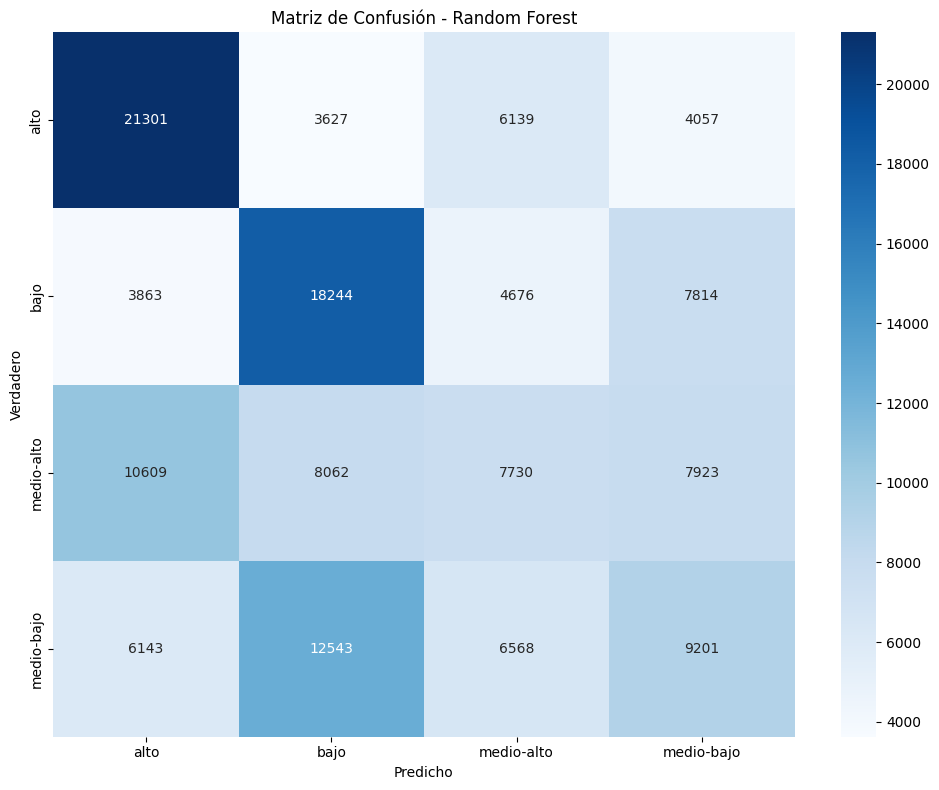


Reporte de Clasificación:
              precision    recall  f1-score   support

        alto       0.51      0.61      0.55     35124
        bajo       0.43      0.53      0.47     34597
  medio-alto       0.31      0.23      0.26     34324
  medio-bajo       0.32      0.27      0.29     34455

    accuracy                           0.41    138500
   macro avg       0.39      0.41      0.39    138500
weighted avg       0.39      0.41      0.40    138500



In [9]:
# Matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, 
            yticklabels=le_target.classes_)
plt.title('Matriz de Confusión - Random Forest')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print("="*60)
print(classification_report(y_val, y_val_pred, target_names=le_target.classes_))

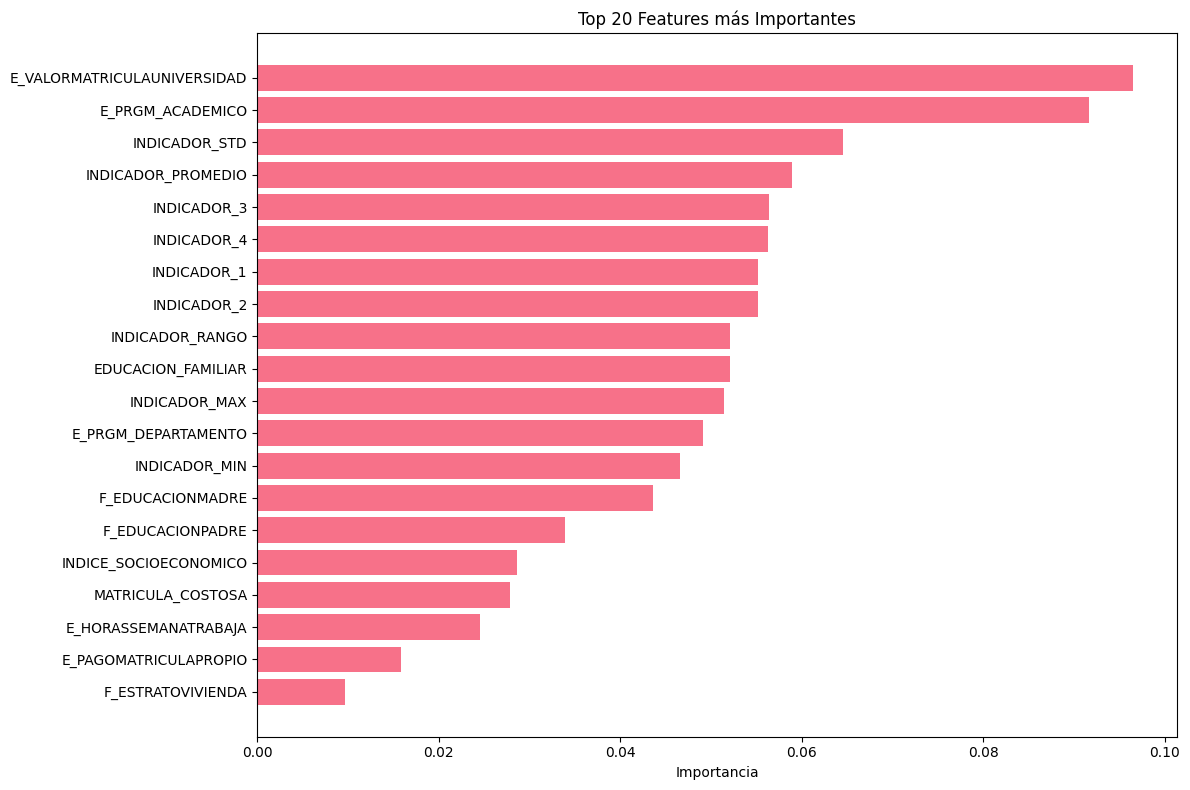


Top 10 Features:
                    feature  importance
E_VALORMATRICULAUNIVERSIDAD    0.096514
           E_PRGM_ACADEMICO    0.091648
              INDICADOR_STD    0.064511
         INDICADOR_PROMEDIO    0.058911
                INDICADOR_3    0.056389
                INDICADOR_4    0.056312
                INDICADOR_1    0.055202
                INDICADOR_2    0.055196
            INDICADOR_RANGO    0.052143
         EDUCACION_FAMILIAR    0.052092


In [10]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importancia')
plt.title('Top 20 Features más Importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(feature_importance.head(10).to_string(index=False))

## 10. Generar Predicciones para Kaggle

In [11]:
# Preparar datos de test
X_test = df_test_fe.copy()

# Asegurar mismas columnas que train
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0

X_test = X_test[X.columns]

print(f"✓ Test data preparado: {X_test.shape}")

✓ Test data preparado: (296786, 26)


In [12]:
# Hacer predicciones
y_test_pred_encoded = model.predict(X_test)
y_test_pred = le_target.inverse_transform(y_test_pred_encoded)

print("Distribución de predicciones:")
print(pd.Series(y_test_pred).value_counts(normalize=True).sort_index())

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s


Distribución de predicciones:
alto          0.307562
bajo          0.300240
medio-alto    0.182199
medio-bajo    0.210000
Name: proportion, dtype: float64


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    2.7s finished


In [13]:
# Crear submission file
submission = pd.DataFrame({
    'ID': test_ids,
    'RENDIMIENTO_GLOBAL': y_test_pred
})

submission.to_csv('submission.csv', index=False)

print("✓ Archivo submission.csv creado")
print(f"  Total predicciones: {len(submission):,}")
print("\nPrimeras filas:")
print(submission.head(10))

✓ Archivo submission.csv creado
  Total predicciones: 296,786

Primeras filas:
       ID RENDIMIENTO_GLOBAL
0  550236               alto
1   98545         medio-bajo
2  499179               alto
3  782980               bajo
4  785185               bajo
5   58495         medio-bajo
6  705444               alto
7  557548               alto
8  519909               bajo
9  832058         medio-alto


## 11. Resumen Final

In [14]:
print("="*80)
print("RESUMEN DE LA SOLUCIÓN")
print("="*80)

print(f"\n📊 DATOS:")
print(f"  Train: {df_train.shape[0]:,} registros")
print(f"  Test: {df_test.shape[0]:,} registros")
print(f"  Features: {X.shape[1]} (después de feature engineering)")

print(f"\n🎯 VARIABLE OBJETIVO:")
print(f"  Clases: {len(le_target.classes_)} (alto, bajo, medio-alto, medio-bajo)")
print(f"  Dataset balanceado")

print(f"\n🏆 MODELO: Random Forest Optimizado")
print(f"  Train Accuracy: {train_acc:.4f}")
print(f"  Validation Accuracy: {val_acc:.4f}")
print(f"  Cross-Validation: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print(f"\n🔧 PREPROCESAMIENTO:")
print(f"  - Ordinal encoding para variables ordinales")
print(f"  - Binary encoding para Si/No")
print(f"  - Label encoding para categorías con muchos valores")
print(f"  - Feature engineering: 8 nuevas features")

print(f"\n📁 ARCHIVOS GENERADOS:")
print(f"  - submission.csv (listo para Kaggle)")

print("\n" + "="*80)
print("✓ SOLUCIÓN COMPLETADA")
print("="*80)
print("\n👉 Siguiente paso: Subir submission.csv a Kaggle")

RESUMEN DE LA SOLUCIÓN

📊 DATOS:
  Train: 692,500 registros
  Test: 296,786 registros
  Features: 26 (después de feature engineering)

🎯 VARIABLE OBJETIVO:
  Clases: 4 (alto, bajo, medio-alto, medio-bajo)
  Dataset balanceado

🏆 MODELO: Random Forest Optimizado
  Train Accuracy: 0.7530
  Validation Accuracy: 0.4078
  Cross-Validation: 0.4061 (+/- 0.0022)

🔧 PREPROCESAMIENTO:
  - Ordinal encoding para variables ordinales
  - Binary encoding para Si/No
  - Label encoding para categorías con muchos valores
  - Feature engineering: 8 nuevas features

📁 ARCHIVOS GENERADOS:
  - submission.csv (listo para Kaggle)

✓ SOLUCIÓN COMPLETADA

👉 Siguiente paso: Subir submission.csv a Kaggle
